## Jata Dil Exp looking at:
 1. Conc estimates over time
 2. Inhibit time 
 3. Proportion looking and related to proportion seeing
 


In [6]:
## start with just average conc estimate over time across all runs assume that they are all the same
## these are unclassified but shockingly clean ... maybe should have juiced the PMTs ... 
## So just going to assume all iamges are jata

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path



In [4]:
test_df = pd.read_csv("../IFCBData/dilExp/jataHighV/hablab_jata_highV/merged/D20260124T011921_IFCB149_adc_only.csv")

In [5]:
print(test_df.columns.tolist())
print(test_df["IsZeroRoi"].head(n=25))

['RoiNumber', 'ADCtime', 'RunTime', 'InhibitTime', 'InhibitTimeDiff', 'VolumeAnalyzed', 'IsZeroRoi', 'RoiHeight', 'RoiWidth', 'RoiX', 'RoiY']
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
Name: IsZeroRoi, dtype: int64


In [6]:
roi_df = test_df.loc[test_df["IsZeroRoi"] == 0].copy()
roi_df["roi_count"] = range(1, len(roi_df) + 1)
roi_df["roi_ml"] = roi_df["roi_count"] / roi_df["VolumeAnalyzed"]


In [7]:
print(roi_df.head())

   RoiNumber    ADCtime    RunTime  InhibitTime  InhibitTimeDiff  \
0          2  10.351653  10.374661     0.074460         0.074460   
1          3  10.461569  10.485228     0.159918         0.085458   
2          4  10.614478  10.637895     0.245078         0.085161   
3          5  10.723870  10.745627     0.328887         0.083809   
4          6  10.813470  10.835391     0.413095         0.084208   

   VolumeAnalyzed  IsZeroRoi  RoiHeight  RoiWidth  RoiX  RoiY  roi_count  \
0        0.042918          0         44        80   932   350          1   
1        0.043022          0         52        80   916   430          2   
2        0.043303          0         52        88   908   358          3   
3        0.043403          0         44        72   924   270          4   
4        0.043426          0         52        80   916   142          5   

       roi_ml  
0   23.300514  
1   46.487707  
2   69.278619  
3   92.159347  
4  115.137778  


In [8]:
roi_df["VolumeAnalyzed"] = pd.to_numeric(roi_df["VolumeAnalyzed"], errors="coerce")
roi_df["roi_count"] = pd.to_numeric(roi_df["roi_ml"], errors="coerce")

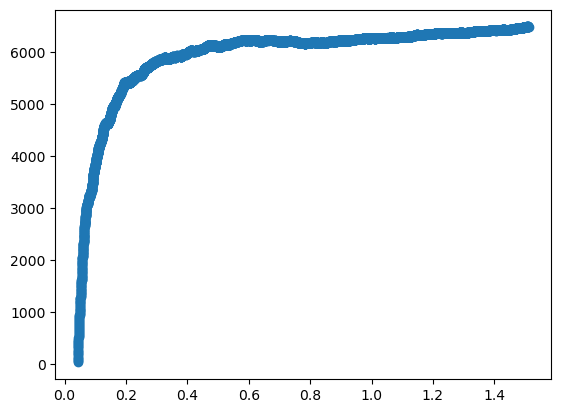

In [9]:
plt.figure()
plt.scatter(roi_df['VolumeAnalyzed'],roi_df["roi_ml"])
plt.show()

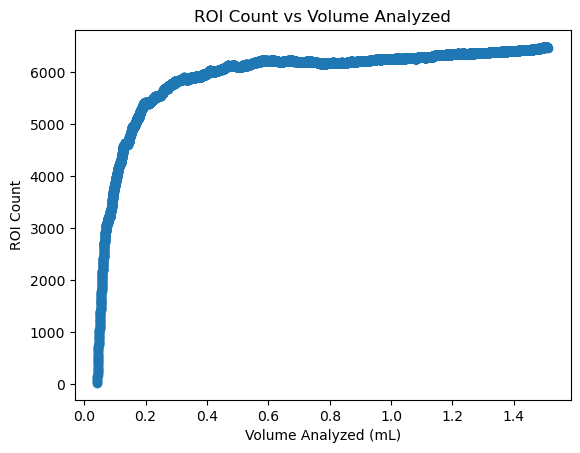

In [10]:

plt.figure()
plt.scatter(roi_df["VolumeAnalyzed"], roi_df["roi_ml"])
plt.xlabel("Volume Analyzed (mL)")
plt.ylabel("ROI Count")
plt.title("ROI Count vs Volume Analyzed")
plt.savefig("../Figs/test.png")
plt.show()


In [60]:
data_dir = Path("../IFCBData/dilExp/jataLowV/hablab_jata_lowV/merged/IFCB124/")

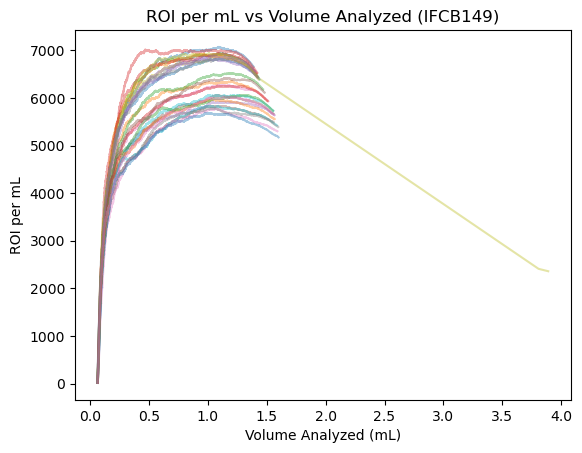

<Figure size 1500x900 with 0 Axes>

In [61]:


plt.figure()

for csv_file in data_dir.glob("*.csv"):
    df = pd.read_csv(csv_file)

    # --- subset & copy ---
    if "IsZeroRoi" not in df.columns:
        continue  # skip files that don't match schema

    df = df.loc[df["IsZeroRoi"] == 0].copy()

    if df.empty:
        continue

    # --- ensure ordering ---
    df = df.sort_values("VolumeAnalyzed")

    # --- create counter ---
    df["roi_count"] = range(1, len(df) + 1)

    # --- compute roi/ml ---
    df["roi_ml"] = df["roi_count"] / df["VolumeAnalyzed"]

    # --- plot ---
    plt.plot(
        df["VolumeAnalyzed"],
        df["roi_ml"],
        alpha=0.4
    )

plt.xlabel("Volume Analyzed (mL)")
plt.ylabel("ROI per mL")
plt.title("ROI per mL vs Volume Analyzed (IFCB149)")
plt.figure(figsize=(10,6),dpi=150)
#plt.savefig("../Figs/IFCB149LowVConc.png")
plt.show()

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_two_dirs(data_dir1, data_dir2, pattern="*.csv",save_path=None):
    data_dir1 = Path(data_dir1)
    data_dir2 = Path(data_dir2)

    # Collect files
    files1 = sorted(data_dir1.glob(pattern))
    files2 = sorted(data_dir2.glob(pattern))

    fig, ax = plt.subplots(figsize=(14, 7), dpi=150)

    # Colormap setup for each directory
    cmap1 = cm.get_cmap("Blues")
    cmap2 = cm.get_cmap("Reds")

    def plot_group(files, cmap, label_prefix):
        n = len(files)
        if n == 0:
            return None, None

        # normalizer for colorbar
        norm = Normalize(vmin=0, vmax=max(n-1, 1))
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])  # required for colorbar later

        for i, csv_file in enumerate(files):
            try:
                df = pd.read_csv(csv_file)
            except Exception as e:
                print(f"Skipping {csv_file.name}: read error: {e}")
                continue

            if "IsZeroRoi" not in df.columns or "VolumeAnalyzed" not in df.columns:
                # skip non-matching files
                continue

            df = df.loc[df["IsZeroRoi"] == 0].copy()
            if df.empty:
                continue

            df = df.sort_values("VolumeAnalyzed")
            df["roi_count"] = range(1, len(df) + 1)
            # avoid division by zero
            df["VolumeAnalyzed"] = pd.to_numeric(df["VolumeAnalyzed"], errors="coerce")
            df = df[(df["VolumeAnalyzed"] > 0) & (df["VolumeAnalyzed"] < 2)]  ## including this because something wierd is happening with VA
                                                                            ### Look more into this is a cluggy fix
            if df.empty:
                continue

            df["roi_ml"] = df["roi_count"] / df["VolumeAnalyzed"]

            # pick a color from the colormap
            t = i / (n - 1) if n > 1 else 0.5
            color = cmap(t)

            # alpha and linewidth can be tuned
            ax.plot(df["VolumeAnalyzed"], df["roi_ml"],
                    color=color, alpha=0.5, linewidth=1.0)
            # (optional) label each file if you want a legend for small N:
            # ax.plot(..., label=csv_file.stem)

        return sm, norm

    sm1, norm1 = plot_group(files1, cmap1, "dir1")
    sm2, norm2 = plot_group(files2, cmap2, "dir2")

    ax.set_xlabel("Volume Analyzed (mL)")
    ax.set_ylabel("ROI per mL")
    ax.set_title("ROI per mL vs Volume Analyzed IFCB 149 (LowV=blue, HighV=red)")

    # smart legend: only show per-file legend if small number of lines
    total_lines = len(ax.lines)
    if total_lines <= 20:
        ax.legend([l.get_label() for l in ax.lines if l.get_label() and not l.get_label().startswith("_")],
                  fontsize=8, loc="best")

    # Add colorbars (if there were files)
    # place two small vertical colorbars on the right, offset by pad
    if sm1 is not None:
        cbar1 = fig.colorbar(sm1, ax=ax, fraction=0.03, pad=0.02)
        cbar1.set_label(f'Files in {data_dir1.name} (order → color)')
    if sm2 is not None:
        cbar2 = fig.colorbar(sm2, ax=ax, fraction=0.03, pad=0.12)
        cbar2.set_label(f'Files in {data_dir2.name} (order → color)')

    ax.grid(alpha=0.2)
    fig.autofmt_xdate()

     # ---- save if requested ----
    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)

        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight"
        )
        print(f"Saved figure to: {save_path}")
    plt.show()



/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_38729/3237162585.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap("Blues")
/var/folders/l8/3r0hwyy91wg_66xlwdssv2yr0000gn/T/ipykernel_38729/3237162585.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap("Reds")


Saved figure to: ../Figs/IFCB149RoisOverVolumeAnalyzed.png


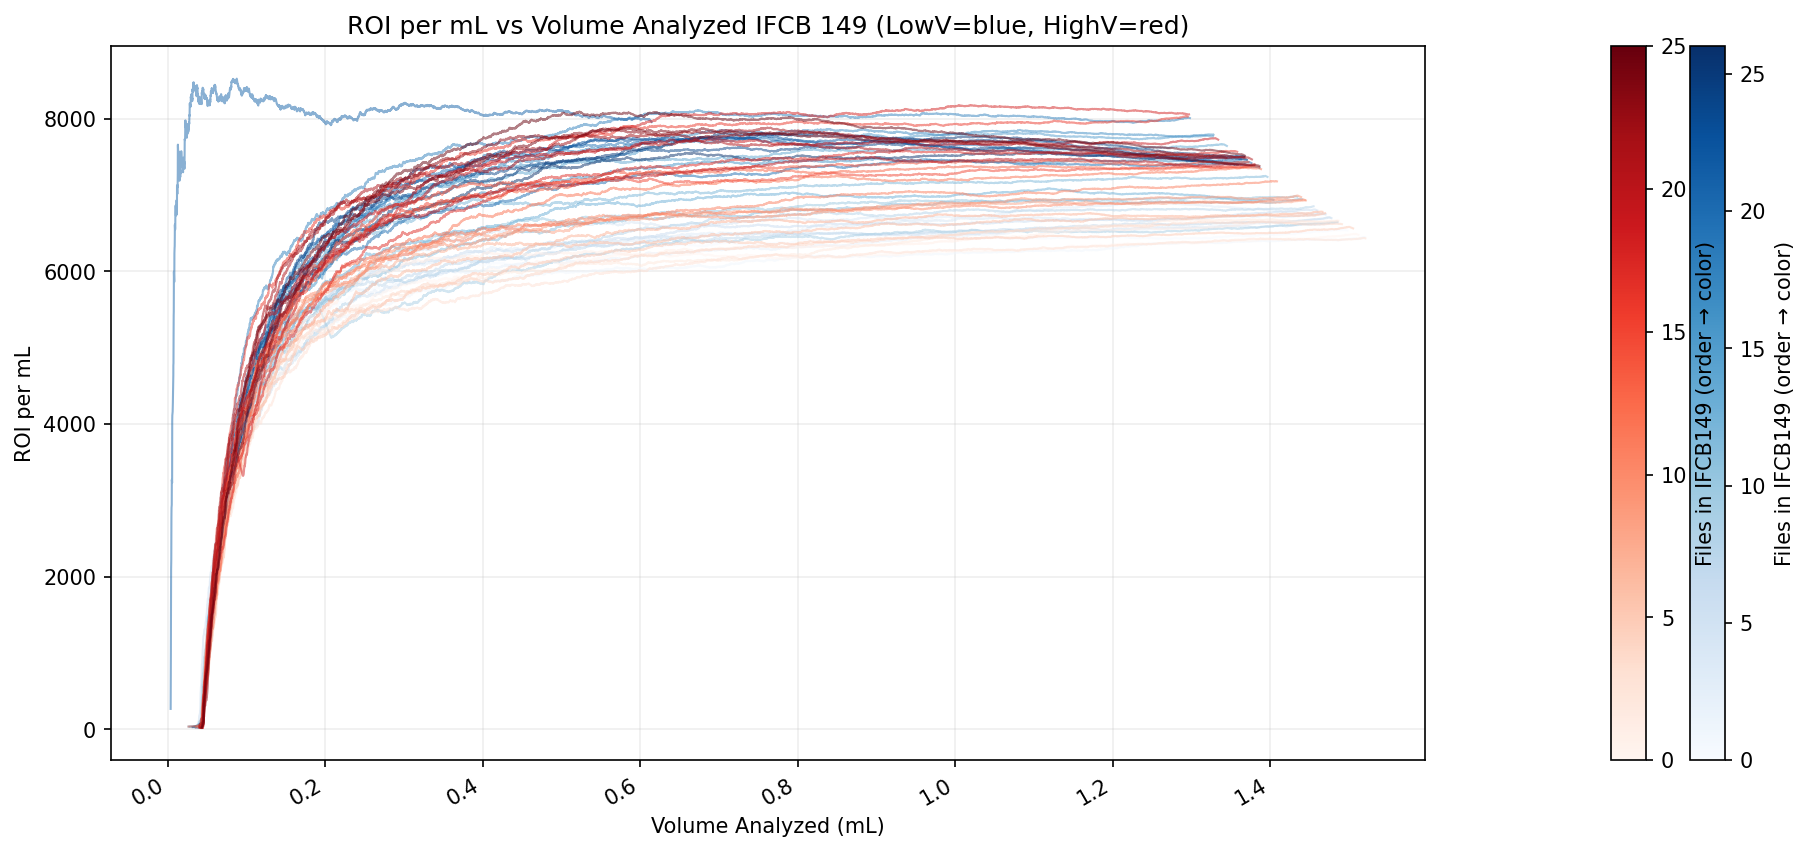

In [118]:
# === USAGE ===
data_dir1 = "../IFCBData/dilExp/jataLowV/hablab_jata_lowV/merged/IFCB149/"
data_dir2 = "../IFCBData/dilExp/jataHighV/hablab_jata_highV/merged/IFCB149/"

plot_two_dirs(data_dir1, data_dir2,save_path="../Figs/IFCB149RoisOverVolumeAnalyzed.png")


In [107]:
## Try to figure out which file has 4 ml volume Analyzed

max_volume = -float("inf")
max_file = None

for csv_file in Path(data_dir1).glob("*.csv"):
    df = pd.read_csv(csv_file)

    if "VolumeAnalyzed" not in df.columns:
        continue

    file_max = df["VolumeAnalyzed"].max()

    if pd.isna(file_max):
        continue

    if file_max > max_volume:
        max_volume = file_max
        max_file = csv_file.name

print("File with largest VolumeAnalyzed:")
print(max_file)
print("Max VolumeAnalyzed:", max_volume)

File with largest VolumeAnalyzed:
D20260124T203052_IFCB124_adc_only.csv
Max VolumeAnalyzed: 3.891248263888889


In [19]:
testdf=pd.read_csv("../IFCBData/dilExp/jataLowV/hablab_jata_lowV/merged/IFCB124/D20260124T211717_IFCB124_adc_only.csv")

In [21]:
print(testdf.tail(n=5))

      RoiNumber      ADCtime      RunTime  InhibitTime  InhibitTimeDiff  \
9980       9982  1200.343219  1200.391667   856.799583         0.083542   
9981       9983  1200.550477  1200.600000   856.885208         0.085625   
9982       9984  1200.658890  1200.711111   856.973681         0.088472   
9983       9985  1200.844497  1200.914583   857.042847         0.069167   
9984       9986  1200.911410  1200.959028   857.053681         0.010833   

      VolumeAnalyzed  IsZeroRoi  RoiHeight  RoiWidth  RoiX  RoiY  
9980        1.431634          1          0         0     0     0  
9981        1.432145          1          0         0     0     0  
9982        1.432239          1          0         0     0     0  
9983        1.432799          1          0         0     0     0  
9984        1.432939          1          0         0     0     0  


In [29]:
print(testdf.tail())

      RoiNumber      ADCtime      RunTime  InhibitTime  InhibitTimeDiff  \
9980       9982  1200.343219  1200.391667   856.799583         0.083542   
9981       9983  1200.550477  1200.600000   856.885208         0.085625   
9982       9984  1200.658890  1200.711111   856.973681         0.088472   
9983       9985  1200.844497  1200.914583   857.042847         0.069167   
9984       9986  1200.911410  1200.959028   857.053681         0.010833   

      VolumeAnalyzed  IsZeroRoi  RoiHeight  RoiWidth  RoiX  RoiY  
9980        1.431634          1          0         0     0     0  
9981        1.432145          1          0         0     0     0  
9982        1.432239          1          0         0     0     0  
9983        1.432799          1          0         0     0     0  
9984        1.432939          1          0         0     0     0  


In [27]:
idx = testdf["VolumeAnalyzed"].idxmax()
max_row = testdf.loc[idx]

In [30]:
print(testdf.loc[idx-5:idx+5])

      RoiNumber      ADCtime      RunTime  InhibitTime  InhibitTimeDiff  \
9163       9165  1084.674170  1084.721250   785.839861         0.085208   
9164       9166  1084.770910  1084.818750   785.926528         0.086667   
9165       9167  1084.881982  1084.929236   786.012153         0.085625   
9166       9168  1084.985119  1085.031597   786.097708         0.085556   
9167       9169  1085.080875  1085.126042   786.180486         0.082778   
9168       9170  1085.306242  1085.353472    78.584063         0.000000   
9169       9171  1085.424979  1085.472153   786.352639       707.768576   
9170       9172  1085.523475  1085.572431   786.440417         0.087778   
9171       9173  1085.620391  1085.667847   786.526319         0.085903   
9172       9174  1085.720532  1085.766806   786.610139         0.083819   
9173       9175  1085.819588  1085.867986   786.696736         0.086597   

      VolumeAnalyzed  IsZeroRoi  RoiHeight  RoiWidth  RoiX  RoiY  
9163        1.245339          0 

In [31]:
## THIS IS very strange not sure what is causing this I might delete all data and redownload because there is no obvious place where this issue would happen in the code and the raw data looks okay

In [79]:
data_dir = Path("../IFCBData/dilExp/jataLowV/hablab_jata_lowV/merged/IFCB149/")

In [80]:

results = []  # collect per-file summaries

for csv_file in data_dir.glob("*.csv"):
    df = pd.read_csv(csv_file)

    if "IsZeroRoi" not in df.columns:
        continue

    # --- subset & copy ---
    df = df.loc[df["IsZeroRoi"] == 0].copy()
    if df.empty:
        continue

    # --- ensure ordering ---
    df = df.sort_values("VolumeAnalyzed")

    # --- counter & roi/ml ---
    df["roi_count"] = range(1, len(df) + 1)
    df["roi_ml"] = df["roi_count"] / df["VolumeAnalyzed"]

    # --- volume window ---
    window = df.loc[
        (df["VolumeAnalyzed"] >= 0.5) &
        (df["VolumeAnalyzed"] <= 1)
    ]

    if window.empty:
        avg_roi_ml = float("nan")
    else:
        avg_roi_ml = window["roi_ml"].mean()

    # --- store result ---
    results.append({
        "file": csv_file.name,
        "avg_roi_ml": avg_roi_ml
    })

# --- final summary dataframe ---
avgLowV_149df = pd.DataFrame(results)

In [89]:
print(avgLowV_149df.tail(n=6))

                                     file   avg_roi_ml     datetime_str  \
21  D20260124T131949_IFCB149_adc_only.csv  7690.363728  20260124T131949   
22  D20260124T184511_IFCB149_adc_only.csv  7711.011820  20260124T184511   
23  D20260124T053500_IFCB149_adc_only.csv  6454.233841  20260124T053500   
24  D20260124T223735_IFCB149_adc_only.csv  7483.218334  20260124T223735   
25  D20260124T123320_IFCB149_adc_only.csv  7517.829809  20260124T123320   
26  D20260124T110023_IFCB149_adc_only.csv  7066.037392  20260124T110023   

              datetime  
21 2026-01-24 13:19:49  
22 2026-01-24 18:45:11  
23 2026-01-24 05:35:00  
24 2026-01-24 22:37:35  
25 2026-01-24 12:33:20  
26 2026-01-24 11:00:23  


In [82]:
## splitting out datetime 

avgLowV_149df["datetime_str"] = (
    avgLowV_149df["file"]
    .str.extract(r"D(\d{8}T\d{6})")
)
avgLowV_149df["datetime"] = pd.to_datetime(
    avgLowV_149df["datetime_str"],
    format="%Y%m%dT%H%M%S"
)


In [95]:
## Make a linear regression
import numpy as np

# x and y data
t = (
    avgHighV_149df["datetime"] - avgHighV_149df["datetime"].min()
).dt.total_seconds() / 3600

y = avgHighV_149df["avg_roi_ml"].values

# remove NaNs (important!)
mask = ~np.isnan(t) & ~np.isnan(y)
t = t[mask]
y = y[mask]

# linear fit
m, b = np.polyfit(t, y, 1)

print(f"Slope (m): {m}")
print(f"Intercept (b): {b}")


Slope (m): 91.48387274503013
Intercept (b): 6118.872231682954


In [96]:
t_fit = np.linspace(t.min(), t.max(), 100)
y_fit = m * t_fit + b

# convert numeric time back to datetime
dt_fit = avgHighV_149df["datetime"].min() + pd.to_timedelta(t_fit, unit="D")

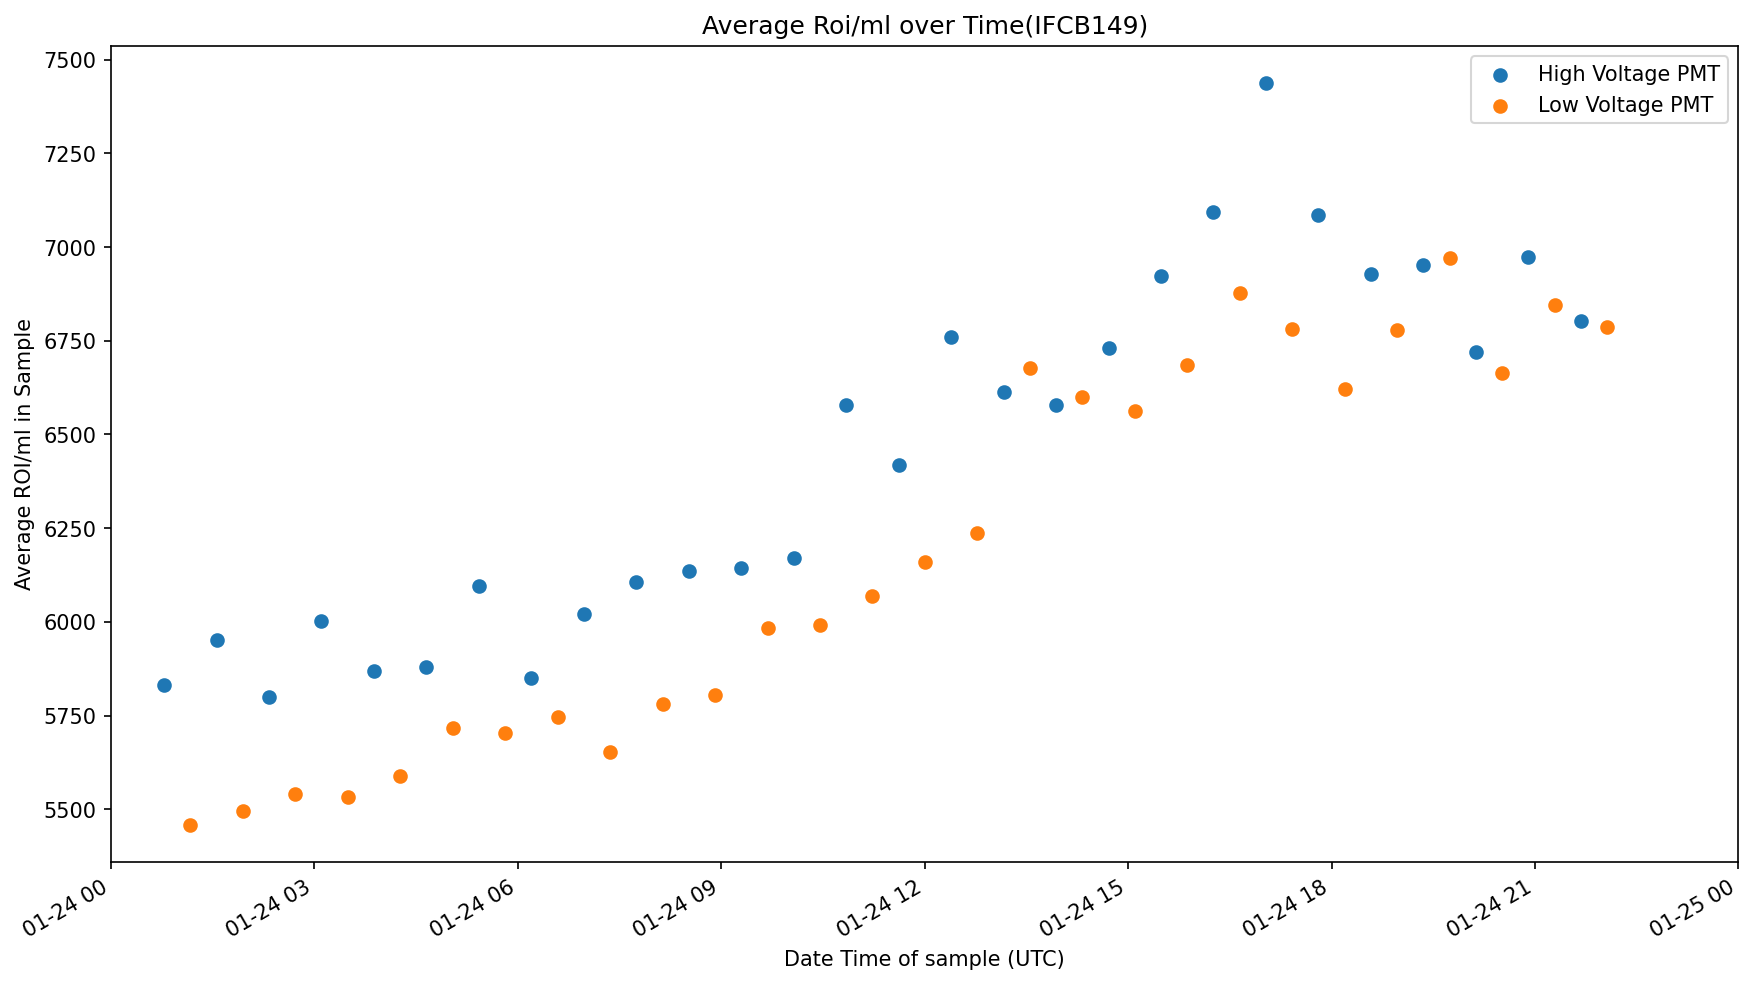

In [101]:
plt.figure(figsize=(14,8), dpi = 150)
plt.scatter(avgHighV_124df["datetime"],avgHighV_124df["avg_roi_ml"], label = "High Voltage PMT")
plt.scatter(avgLowV_124df["datetime"],avgLowV_124df["avg_roi_ml"], label = "Low Voltage PMT")
plt.xlabel("Date Time of sample (UTC)")
plt.xlim(pd.Timestamp("2026-01-24 00:00:00"),pd.Timestamp("2026-01-25 00:00:00"))
plt.ylabel("Average ROI/ml in Sample")
plt.title("Average Roi/ml over Time(IFCB149)")
#plt.plot(dt_fit, y_fit, label="Linear fit")
plt.gcf().autofmt_xdate()
plt.legend()
#plt.savefig("../Figs/IFCB124AverageRoiMLOverTime.png")
plt.show()